In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import intersection
import settings
import nuts
import plots

# Load environmental zones by Metzger et al. (2008)

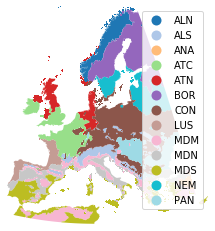

In [2]:
enz_geo = (
    geopandas
    .read_file(settings.ENZ_GIS_PATH)
    .set_index('EnZ_name')
    [["geometry"]]
)
ax = enz_geo.reset_index().plot('EnZ_name', cmap='tab20', legend=True).axes
plots.adj_geoplot(ax)

# Load NUTS regions GIS data

In [3]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')

# Read permanent grassland yield data from Smit et al. (2008)

In [4]:
enz_yield = pd.read_csv('indata/smit-2008-grassland-yields.csv', index_col=['EnZ_name'])
enz_yield

,EnZ_label,yield
EnZ_name,,
ALN,Alpine North,4.04
BOR,Boreal,3.09
NEM,Nemoral,3.36
ATN,Atlantic North,7.42
ALS,Alpine South,3.25
CON,Continental,4.29
ATC,Atlantic Central,6.96
PAN,Pannonian,1.90
LUS,Lusitatnian,5.20


# Calculate share of each environmental zone in each NUTS region

In [5]:
enz_shares = intersection.get_share(enz_geo, nuts_geo)
enz_shares

EnZ_name  NUTS_ID
ALN       FI         0.080113
          FI1        0.080326
          FI1D       0.118197
          FI1D7      0.272442
          NO         0.619838
                       ...   
PAN       SK032      0.260245
          TR         0.000209
          TR2        0.003828
          TR21       0.008676
          TR213      0.024984
Name: share, Length: 3415, dtype: float64

In [6]:
# Sanity check: shares should add up to about 100% in each region
enz_shares.groupby("NUTS_ID").sum().describe()

count    1848.000000
mean        0.992809
std         0.057408
min         0.031100
25%         0.999389
50%         1.000000
75%         1.000000
max         1.015903
Name: share, dtype: float64

In [7]:
# Environmental zone coverage is evidently not 100% everywhere,
# but it is good (>= 97%) in all the NUTS regions we use here
included_nuts = nuts.get_included_regions()
enz_shares.groupby('NUTS_ID').sum()[included_nuts].describe()

count    233.000000
mean       0.998092
std        0.004204
min        0.969086
25%        0.998284
50%        1.000000
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [8]:
# To deal with the few NUTS regions that are only ~97% covered by environmental zones,
# calculate weights that by definition add up to 100% in each NUTS region.
# To avoid any mistakes, let's only include the NUTS regions used in this analysis.
enz_weights = (
    enz_shares
    .groupby('NUTS_ID')
    .apply(lambda s: s / s.sum())
    .loc[:, included_nuts]
)
enz_weights.groupby('NUTS_ID').sum().describe().round(5)

count    233.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [9]:
enz_weights.to_csv("outdata/enz-weights-by-nuts.csv", header=True)

# Calculate grassland yield as weighted average of environmental zones

In [10]:
nuts_yield = (
    enz_yield['yield']
    .mul(enz_weights)
    .groupby('NUTS_ID')
    .sum()
    .rename('yield')
)
nuts_yield

NUTS_ID
AT11    2.560994
AT12    3.461973
AT13    1.900000
AT21    3.423663
AT22    3.668595
          ...   
UKM2    7.420000
UKM3    7.420000
UKM5    7.420000
UKM6    7.420000
UKN0    7.419092
Name: yield, Length: 233, dtype: float64

# Inspect to see that datasets look similar

/home/rasmus/.local/share/virtualenvs/eu-p-budget-YA21ty_Y/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


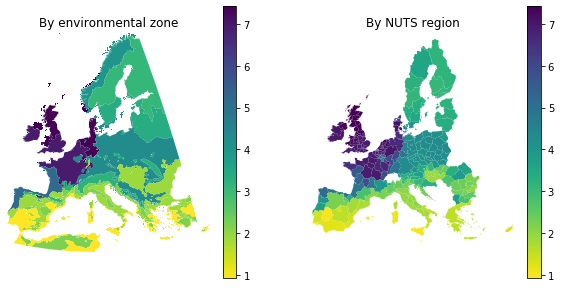

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

data = {
    'By environmental zone': enz_geo.join(enz_yield),
    'By NUTS region': nuts_geo.join(nuts_yield).dropna(),
}

for (title, d), ax in zip(data.items(), axs):
    d.plot('yield', cmap='viridis_r', legend=True, ax=ax)
    ax.set_title(title)
    plots.adj_geoplot(ax)

In [12]:
nuts_yield.to_csv('outdata/permanent_grassland_yield_by_nuts.csv', header=True)